# Car Racing

In [2]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import threading
from IPython import display

%matplotlib inline
env = gym.make('CarRacing-v0')

/usr/local/lib/python3.5/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
!python3 -V

Python 3.5.2


In [11]:
import tensorflow as tf
tf.__version__

'1.15.0'

## env visualization

In [2]:
!pip install pyglet==1.5.0
!pip install pyvirtualdisplay
!apt-get install -y xvfb

import pyvirtualdisplay

# 가상 디스플레이 생성
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.18.4-0ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 216 not upgraded.


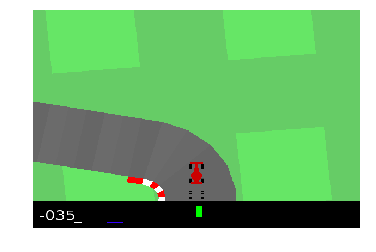

In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


# 환경 초기화
observation = env.reset()

done = False
while not done:
    # 화면 시각화
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    # 무작위로 액션 선택 (랜덤 조향과 가속도)
    action = env.action_space.sample()

    # 액션을 환경에 적용하고, 다음 상태, 보상, 종료 여부 등을 얻음
    observation, reward, done, info = env.step(action)

# 환경 종료 및 시각화 창 닫기
env.close()

### with DQN

---------------------------------------------

In [3]:
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(-1, 1, self.action_size)
        return np.argmax(self.model.predict(state)[0])

    def replay(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)
        for idx in minibatch:
            state, action, reward, next_state, done = self.memory[idx]
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                target[0][action] = reward + self.gamma * np.max(self.model.predict(next_state))
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def preprocess_state(self, state):
        # Convert the RGB image to grayscale
        state = np.dot(state[..., :3], [0.2989, 0.5870, 0.1140])
        # Resize the state to (96, 96)
        state = np.resize(state, (96, 96))
        # Scale the state between 0 and 1
        state /= 255.0
        # Add an extra dimension to represent the channel
        state = np.expand_dims(state, axis=-1)
        # Add a batch dimension
        state = np.expand_dims(state, axis=0)
        return state

    def train(self, env, num_episodes=10, batch_size=16):
        for episode in range(num_episodes):
            state = env.reset()
            state = self.preprocess_state(state)
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                if done:
                    print("Episode:", episode, "Total Reward:", total_reward)

# Get the state and action sizes
state_size = (96, 96, 1)
action_size = env.action_space.shape[0]

# Create an instance of the DQNAgent
agent = DQNAgent(state_size, action_size)

# Train the agent
agent.train(env, num_episodes=10)
agent.model.save_weights('dqn_weights.h5')

# Test the agent
state = env.reset()
state = agent.preprocess_state(state)
done = False
total_reward = 0
while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = agent.preprocess_state(next_state)
    state = next_state
    total_reward += reward
env.close()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Track generation: 988..1243 -> 255-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 906..1145 -> 239-tiles track
Episode: 0 Total Reward: -36.974789915966845
Track generation: 1023..1289 -> 266-tiles track
Episode: 1 Total Reward: -47.16981132075544
Track generation: 1229..1540 -> 311-tiles track
Episode: 2 Total Reward: -54.838709677420205
Track generation: 940..1179 -> 239-tiles track
Episode: 3 Total Reward: -36.9747899159669
Track generation: 1247..1563 -> 316-tiles track
Episode: 4 Total Reward: -52.38095238095314
Track generation: 1069..1340 -> 271-tiles track
Episode: 5 Total Reward: -44.44444444444518
Track generation: 1100..1379 -> 279-tiles track
Episode: 6 Total Reward: -46.0431654676266
Track generation: 1181..1480 -> 299-tiles track
Episode: 7 Total Reward: -49.664429530202106
Track generation: 1203..1508 -> 305-tiles track
Episode: 

---

### Result

/usr/local/lib/python3.5/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1304..1634 -> 330-tiles track


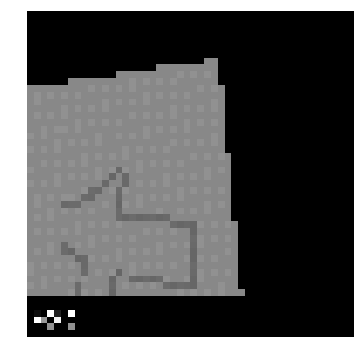

In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Create the environment
env = gym.make("CarRacing-v0")

# Get the state and action sizes
state_size = (96, 96, 1)
action_size = env.action_space.shape[0]

# Create an instance of the DQNAgent
agent = DQNAgent(state_size, action_size)

# Load the trained weights
agent.model.load_weights('dqn_weights.h5')

# Function to preprocess the state
def preprocess_state(state):
    state = np.mean(state, axis=2, keepdims=True)
    state = state[::2, ::2, :]  # Downsample by taking every second pixel
    state = state / 255.0  # Scale to 0-1 range
    return state

# Initialize the environment
state = env.reset()
state = preprocess_state(state)

# Visualization
plt.figure(figsize=(6, 6))
img = plt.imshow(state[:, :, 0], cmap='gray')
plt.axis('off')

done = False
while not done:
    # Choose an action
    action = agent.act(state)

    # Take a step in the environment
    next_state, reward, done, _ = env.step(action)
    next_state = preprocess_state(next_state)

    # Update the current state
    state = next_state

    # Render the environment
    img.set_data(state[:, :, 0])
    plt.pause(0.001)
    plt.draw()

# Close the environment
env.close()
